# Model A

En este experimento, con respecto al pasado solamente se modifico el learning rate, los callbacks y las epochs:

```
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss='mse',
              metrics=['mae'])

# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-6)
checkpoint = callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Entrenar el modelo usando el pipeline de tf.data
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=100,
                    callbacks=[early_stop, reduce_lr, checkpoint])
                  
```

# Model A - VERSIÓN CORREGIDA

Esta es la versión **CORREGIDA** de Model A que implementa correctamente el split de datos descrito en el paper:

### Split de Datos Implementado:
- **Training**: 140 imágenes (76%) - Para entrenar el modelo
- **Validation**: 44 imágenes (24%) - Para ajustar hiperparámetros durante entrenamiento
- **Test**: 80 imágenes - Para evaluación final **INDEPENDIENTE**

**Total: 140 + 44 + 80 = 264 imágenes ✓**

### Diferencia con la versión original:
La versión original usaba:
- ❌ Training: 184 imágenes (TODAS del folder Training+Density)
- ❌ Validation: 80 imágenes (del folder Validation+Density)
- ❌ Sin test set independiente

Esta versión corregida:
- ✅ Carga las 184 imágenes de Training+Density
- ✅ Las divide en 140 train / 44 validation
- ✅ Usa las 80 de Validation+Density como test set independiente
- ✅ Es comparable con el Baseline model

---

In [1]:
import os
import numpy as np
import imageio
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device_name = tf.test.gpu_device_name()
print("GPU detectada:", device_name)

GPU detectada: /device:GPU:0


In [4]:
# Rutas de los conjuntos de entrenamiento y validación
train_path = '/content/drive/MyDrive/NCZ/10 Projects/MAA-Cone-Density-Estimation/data/machine1_5/Training+Density/'
val_path   = '/content/drive/MyDrive/NCZ/10 Projects/MAA-Cone-Density-Estimation/data/machine1_5/Validation+Density/'

In [5]:
# Función para leer y preprocesar datos
def read_data(base_path, density_threshold=400):
    data = []
    anno = []
    file_list = os.listdir(base_path)
    for filename in file_list:
        if 'Density' in filename:
            base_filename = filename[:-11] + '.tif'
            img_path = os.path.join(base_path, base_filename)
            dens_path = os.path.join(base_path, filename)
            if os.path.exists(img_path) and os.path.exists(dens_path):
                # Cargar imagen y normalizar a [0,1]
                img = np.asarray(Image.open(img_path).convert("RGB")).astype(np.float32) / 255.0
                # Cargar mapa de densidad
                density = imageio.imread(dens_path).astype(np.float32)
                # Filtrado basado en la suma (ajustar el umbral según se requiera)
                if np.sum(density) / 100 < density_threshold:
                    data.append(img)
                    # Expandir la dimensión para que tenga forma (H, W, 1)
                    density = np.expand_dims(density, axis=-1)
                    anno.append(density)
    return np.array(data), np.array(anno)

# Función similar para el conjunto de prueba (si es necesario)
def read_data_test(base_path, density_threshold=1000):
    data = []
    anno = []
    file_list = os.listdir(base_path)
    for filename in file_list:
        if 'Density' in filename:
            base_filename = filename[:-11] + '.tif'
            img_path = os.path.join(base_path, base_filename)
            dens_path = os.path.join(base_path, filename)
            if os.path.exists(img_path) and os.path.exists(dens_path):
                img = np.asarray(Image.open(img_path).convert("RGB")).astype(np.float32) / 255.0
                density = imageio.imread(dens_path).astype(np.float32)
                if np.sum(density) / 100 < density_threshold:
                    data.append(img)
                    density = np.expand_dims(density, axis=-1)
                    anno.append(density)
    return np.array(data), np.array(anno)

In [ ]:
# Cargar todas las imágenes del conjunto de entrenamiento (184 imágenes)
all_train_images, all_train_density_maps = read_data(train_path, density_threshold=400)

# Split programático: 140 para training, 44 para validation
train_size = 140
train_images = all_train_images[:train_size]
train_density_maps = all_train_density_maps[:train_size]

val_images = all_train_images[train_size:]
val_density_maps = all_train_density_maps[train_size:]

# Cargar el test set independiente (80 imágenes)
test_images, test_density_maps = read_data(val_path, density_threshold=400)

print("=" * 50)
print("SPLIT CORRECTO IMPLEMENTADO (140/44/80)")
print("=" * 50)
print("Train images shape:", train_images.shape)
print("Train density maps shape:", train_density_maps.shape)
print("Validation images shape:", val_images.shape)
print("Validation density maps shape:", val_density_maps.shape)
print("Test images shape:", test_images.shape)
print("Test density maps shape:", test_density_maps.shape)
print("=" * 50)
print(f"Total: {len(train_images)} + {len(val_images)} + {len(test_images)} = {len(train_images) + len(val_images) + len(test_images)} imágenes")
print("=" * 50)

In [7]:
# Función de data augmentation (flip y rotaciones)
def augment(image, density):
    # Flip horizontal aleatorio
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        density = tf.image.flip_left_right(density)
    # Flip vertical aleatorio
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        density = tf.image.flip_up_down(density)
    # Rotación aleatoria múltiplo de 90 grados
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    density = tf.image.rot90(density, k)
    return image, density

# Crear datasets tf.data para entrenamiento y validación
batch_size = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_density_maps))
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, (256,256)), tf.image.resize(y, (256,256))))
train_dataset = train_dataset.map(augment)
train_dataset = train_dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_density_maps))
val_dataset = val_dataset.map(lambda x, y: (tf.image.resize(x, (256,256)), tf.image.resize(y, (256,256))))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
#Construcción del modelo U-Net mejorado
def conv_block(x, filters):
    x = layers.Conv2D(filters, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

# Entrada del modelo
inputs = layers.Input(shape=(256,256,3))

# Encoder
c1, p1 = encoder_block(inputs, 16)
c2, p2 = encoder_block(p1, 32)
c3, p3 = encoder_block(p2, 64)

# Cuello de botella con Dropout para regularización
b = conv_block(p3, 128)
b = layers.Dropout(0.5)(b)

# Decoder
def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (3,3), strides=(2,2), padding='same')(x)
    x = layers.concatenate([x, skip])
    x = conv_block(x, filters)
    return x

d1 = decoder_block(b, c3, 64)
d2 = decoder_block(d1, c2, 32)
d3 = decoder_block(d2, c1, 16)

# Salida: Mapa de densidad con activación ReLU para evitar valores negativos
outputs = layers.Conv2D(1, (1,1), activation='relu')(d3)

model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]  

 Total params: 538,609 (2.05 MB)

 Trainable params: 537,201 (2.05 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [9]:
# Compilar el modelo
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss='mse',
              metrics=['mae'])

# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-6)
checkpoint = callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Entrenar el modelo usando el pipeline de tf.data
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=100,
                    callbacks=[early_stop, reduce_lr, checkpoint])


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.6242 - mae: 0.3624

23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 165ms/step - loss: 1.6200 - mae: 0.3605 - val_loss: 1.3668 - val_mae: 0.1987 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 1.4553 - mae: 0.2952

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 1.4566 - mae: 0.2958 - val_loss: 1.3453 - val_mae: 0.3005 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.5246 - mae: 0.3254

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 1.5222 - mae: 0.3250 - val_loss: 1.3394 - val_mae: 0.3545 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 1.4763 - mae: 0.3295 - val_loss: 1.3490 - val_mae: 0.2666 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 1.4220 - mae: 0.3119 - val_loss: 1.3400 - val_mae: 0.2893 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 1.4524 - mae: 0.3173 - val_loss: 1.3482 - val_mae: 0.2600 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 1.4489 - mae: 0.3211 - val_loss: 1.3425 - val_mae: 0.2612 - learning_rate: 0.0010
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 1.4384 - mae: 0.3168 - val_loss: 1.3434 - val_mae: 0.2677 - learning_rate: 0.0010
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.5112 - mae: 0.3272

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 1.5074 - mae: 0.3267 - val_loss: 1.3324 - val_mae: 0.2112 - learning_rate: 7.0000e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.4604 - mae: 0.3229

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 1.4585 - mae: 0.3227 - val_loss: 1.3192 - val_mae: 0.2826 - learning_rate: 7.0000e-04
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 1.3689 - mae: 0.3027 - val_loss: 1.3324 - val_mae: 0.2135 - learning_rate: 7.0000e-04
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.3503 - mae: 0.3081

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 1.3525 - mae: 0.3082 - val_loss: 1.2923 - val_mae: 0.2586 - learning_rate: 7.0000e-04
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.3929 - mae: 0.3222

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 1.3932 - mae: 0.3221 - val_loss: 1.2872 - val_mae: 0.2786 - learning_rate: 7.0000e-04
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.4575 - mae: 0.3177

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 1.4552 - mae: 0.3174 - val_loss: 1.2824 - val_mae: 0.3070 - learning_rate: 7.0000e-04
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 1.3868 - mae: 0.3028 - val_loss: 1.3046 - val_mae: 0.2453 - learning_rate: 7.0000e-04
Epoch 16/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.3952 - mae: 0.3137

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 1.3951 - mae: 0.3138 - val_loss: 1.2775 - val_mae: 0.3154 - learning_rate: 7.0000e-04
Epoch 17/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.3642 - mae: 0.2994

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 1.3656 - mae: 0.2999 - val_loss: 1.2720 - val_mae: 0.2545 - learning_rate: 7.0000e-04
Epoch 18/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.4366 - mae: 0.3208

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 1.4348 - mae: 0.3204 - val_loss: 1.2627 - val_mae: 0.2602 - learning_rate: 7.0000e-04
Epoch 19/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 1.3480 - mae: 0.2996 - val_loss: 1.3083 - val_mae: 0.2389 - learning_rate: 7.0000e-04
Epoch 20/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.4206 - mae: 0.3176

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 1.4194 - mae: 0.3173 - val_loss: 1.2497 - val_mae: 0.2570 - learning_rate: 7.0000e-04
Epoch 21/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 1.3398 - mae: 0.2992 - val_loss: 1.2859 - val_mae: 0.2408 - learning_rate: 7.0000e-04
Epoch 22/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 1.3878 - mae: 0.3092 - val_loss: 1.2839 - val_mae: 0.2446 - learning_rate: 7.0000e-04
Epoch 23/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 1.3805 - mae: 0.3115 - val_loss: 1.2533 - val_mae: 0.3197 - learning_rate: 7.0000e-04
Epoch 24/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.4382 - mae: 0.3219 - val_loss: 1.2784 - val_mae: 0.2972 - learning_rate: 7.0000e-04
Epoch 25/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 1.4145 - mae: 0.3092 - val_loss: 1.2504 - val_mae: 0.2860 - learning_rate: 7.0000e-04
Epoch 26/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 1.4067 - mae: 0.3077 - val_loss: 1.2592 - val_mae: 0.3136 - learning_r

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 1.3810 - mae: 0.3028 - val_loss: 1.2476 - val_mae: 0.2711 - learning_rate: 4.9000e-04
Epoch 28/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.4576 - mae: 0.3198 - val_loss: 1.2533 - val_mae: 0.2927 - learning_rate: 4.9000e-04
Epoch 29/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.3976 - mae: 0.3011

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 1.3966 - mae: 0.3012 - val_loss: 1.2198 - val_mae: 0.2642 - learning_rate: 4.9000e-04
Epoch 30/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 1.4095 - mae: 0.3121 - val_loss: 1.2229 - val_mae: 0.2797 - learning_rate: 4.9000e-04
Epoch 31/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.4011 - mae: 0.3117 - val_loss: 1.2599 - val_mae: 0.3060 - learning_rate: 4.9000e-04
Epoch 32/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 1.3497 - mae: 0.2988 - val_loss: 1.2470 - val_mae: 0.2713 - learning_rate: 4.9000e-04
Epoch 33/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 1.4216 - mae: 0.3160 - val_loss: 1.2299 - val_mae: 0.2971 - learning_rate: 4.9000e-04
Epoch 34/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.4310 - mae: 0.3118 - val_loss: 1.2206 - val_mae: 0.2846 - learning_rate: 4.9000e-04
Epoch 35/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.4117 - mae: 0.3112

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 1.4098 - mae: 0.3110 - val_loss: 1.2168 - val_mae: 0.2713 - learning_rate: 3.4300e-04
Epoch 36/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 1.3752 - mae: 0.3044 - val_loss: 1.2614 - val_mae: 0.2774 - learning_rate: 3.4300e-04
Epoch 37/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 1.3487 - mae: 0.2981 - val_loss: 1.2252 - val_mae: 0.2878 - learning_rate: 3.4300e-04
Epoch 38/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 1.4237 - mae: 0.3173 - val_loss: 1.2470 - val_mae: 0.2951 - learning_rate: 3.4300e-04
Epoch 39/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 1.4329 - mae: 0.3077 - val_loss: 1.2542 - val_mae: 0.2870 - learning_rate: 3.4300e-04
Epoch 40/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.3553 - mae: 0.2959

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 1.3556 - mae: 0.2961 - val_loss: 1.2117 - val_mae: 0.2567 - learning_rate: 3.4300e-04
Epoch 41/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 1.4354 - mae: 0.3160 - val_loss: 1.2264 - val_mae: 0.2731 - learning_rate: 3.4300e-04
Epoch 42/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 1.3930 - mae: 0.3049 - val_loss: 1.2212 - val_mae: 0.2615 - learning_rate: 3.4300e-04
Epoch 43/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.4029 - mae: 0.3060 - val_loss: 1.2589 - val_mae: 0.2788 - learning_rate: 3.4300e-04
Epoch 44/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 1.3743 - mae: 0.3061 - val_loss: 1.2280 - val_mae: 0.2470 - learning_rate: 3.4300e-04
Epoch 45/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 1.4140 - mae: 0.3082 - val_loss: 1.2252 - val_mae: 0.2634 - learning_rate: 3.4300e-04
Epoch 46/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 1.3779 - mae: 0.2990 - val_loss: 1.2192 - val_mae: 0.2662 - learning_r

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 1.3495 - mae: 0.3033 - val_loss: 1.2099 - val_mae: 0.2766 - learning_rate: 2.4010e-04
Epoch 49/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 1.3419 - mae: 0.2970 - val_loss: 1.2124 - val_mae: 0.2709 - learning_rate: 2.4010e-04
Epoch 50/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 1.4265 - mae: 0.3168 - val_loss: 1.2152 - val_mae: 0.2614 - learning_rate: 2.4010e-04
Epoch 51/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.3945 - mae: 0.3057

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.3929 - mae: 0.3054 - val_loss: 1.2095 - val_mae: 0.2635 - learning_rate: 2.4010e-04
Epoch 52/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.3994 - mae: 0.3074

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 1.3976 - mae: 0.3072 - val_loss: 1.2052 - val_mae: 0.2777 - learning_rate: 2.4010e-04
Epoch 53/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.3223 - mae: 0.2913 - val_loss: 1.2415 - val_mae: 0.2728 - learning_rate: 2.4010e-04
Epoch 54/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 1.4119 - mae: 0.3099 - val_loss: 1.2219 - val_mae: 0.2677 - learning_rate: 2.4010e-04
Epoch 55/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 1.3515 - mae: 0.2994 - val_loss: 1.2431 - val_mae: 0.2685 - learning_rate: 2.4010e-04
Epoch 56/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 1.3509 - mae: 0.3018 - val_loss: 1.2156 - val_mae: 0.2730 - learning_rate: 2.4010e-04
Epoch 57/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 1.3857 - mae: 0.3054 - val_loss: 1.2470 - val_mae: 0.2810 - learning_rate: 2.4010e-04
Epoch 58/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 1.3985 - mae: 0.3090 - val_loss: 1.2199 - val_mae: 0.2709 - learning_r

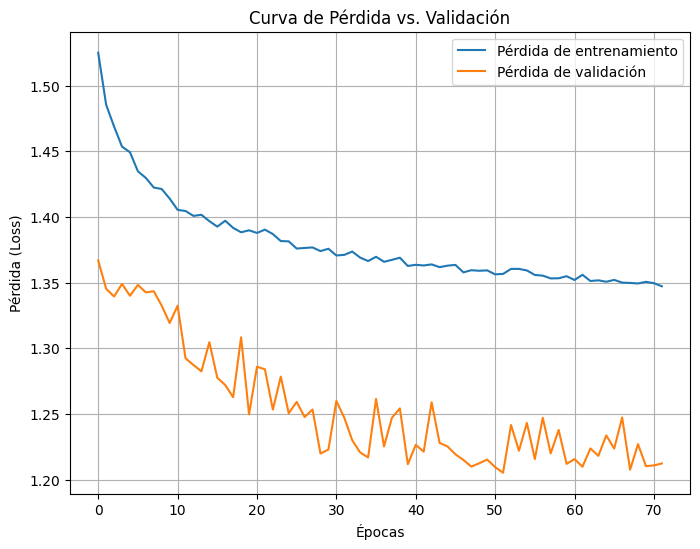

In [10]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.title('Curva de Pérdida vs. Validación')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Evaluación del modelo
model.load_weights('best_model.h5')
val_loss, val_mae = model.evaluate(val_dataset)
print(f"Validación - MSE: {val_loss:.3f}, MAE: {val_mae:.3f}")

# Predicción y visualización de resultados
# Seleccionar un ejemplo del conjunto de validación
for test_img, true_density in val_dataset.take(1):
    test_img_sample = test_img[1]
    true_density_sample = true_density[1]

predicted_map = model.predict(tf.expand_dims(test_img_sample, axis=0)).squeeze()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0905 - mae: 0.2550
Validación - MSE: 1.205, MAE: 0.278
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
# ========================================
# EVALUACIÓN EN TEST SET (80 IMÁGENES)
# ========================================
print("\n" + "="*60)
print("EVALUACIÓN EN TEST SET INDEPENDIENTE (80 imágenes)")
print("="*60)

# Crear dataset de test
batch_size = 8
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_density_maps))
test_dataset = test_dataset.map(lambda x, y: (tf.image.resize(x, (256,256)), tf.image.resize(y, (256,256))))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Evaluar en test set
test_loss, test_mae = model.evaluate(test_dataset)
print(f"\nTest Set - MSE: {test_loss:.3f}, MAE: {test_mae:.3f}")

# Calcular métricas adicionales en test set
test_predictions = model.predict(test_images)
test_pred_counts = np.sum(test_predictions, axis=(1,2,3))
test_true_counts = np.sum(test_density_maps, axis=(1,2,3))

# Métricas de conteo en test set
test_count_mae = np.mean(np.abs(test_true_counts - test_pred_counts))
test_count_mse = np.mean((test_true_counts - test_pred_counts)**2)
test_count_rmse = np.sqrt(test_count_mse)
test_count_mape = np.mean(np.abs((test_true_counts - test_pred_counts) / test_true_counts)) * 100

from sklearn.metrics import r2_score
test_r2 = r2_score(test_true_counts, test_pred_counts)

print("\n--- Métricas de Conteo en Test Set ---")
print(f"MAE (conteo):  {test_count_mae:.2f} cones")
print(f"RMSE (conteo): {test_count_rmse:.2f} cones")
print(f"MAPE:          {test_count_mape:.2f}%")
print(f"R²:            {test_r2:.3f}")
print("="*60 + "\n")

In [ ]:
# Bland-Altman Plot para TEST SET
import statsmodels.api as sm

fig, ax = plt.subplots(1, figsize=(10, 6))
sm.graphics.mean_diff_plot(test_true_counts, test_pred_counts, ax=ax)
ax.set_ylabel('Actual - Predicho (cones)', fontsize=12)
ax.set_xlabel('Promedio [(Actual + Predicho) / 2] (cones)', fontsize=12)
ax.set_title('Bland-Altman Plot - TEST SET (80 imágenes)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calcular límites de acuerdo (mean ± 1.96*SD)
diff_test = test_true_counts - test_pred_counts
mean_diff_test = np.mean(diff_test)
std_diff_test = np.std(diff_test)
loa_upper_test = mean_diff_test + 1.96 * std_diff_test
loa_lower_test = mean_diff_test - 1.96 * std_diff_test

print("\n--- Bland-Altman: Límites de Acuerdo (Test Set) ---")
print(f"Bias (diferencia media):     {mean_diff_test:.2f} cones")
print(f"Límite superior (+1.96 SD):  {loa_upper_test:.2f} cones")
print(f"Límite inferior (-1.96 SD):  {loa_lower_test:.2f} cones")
print(f"Rango de acuerdo:            {loa_upper_test - loa_lower_test:.2f} cones")
print("="*60)

Conteo real: 5400.00 | Conteo predicho: 7393.83


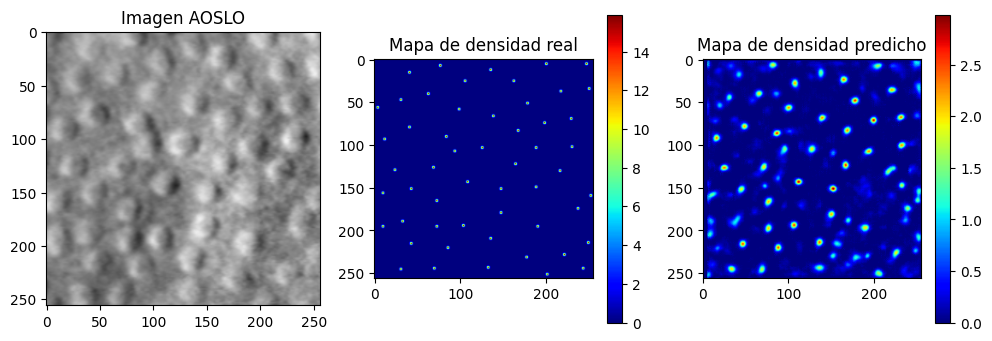

In [12]:
# Cálculo del conteo (suma del mapa)
true_count = np.sum(true_density_sample)
pred_count = np.sum(predicted_map)
print(f"Conteo real: {true_count:.2f} | Conteo predicho: {pred_count:.2f}")

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(test_img_sample)
plt.title("Imagen AOSLO")

plt.subplot(1,3,2)
plt.imshow(true_density_sample[:,:,0], cmap='jet')
plt.title("Mapa de densidad real")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(predicted_map, cmap='jet')
plt.title("Mapa de densidad predicho")
plt.colorbar()

plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


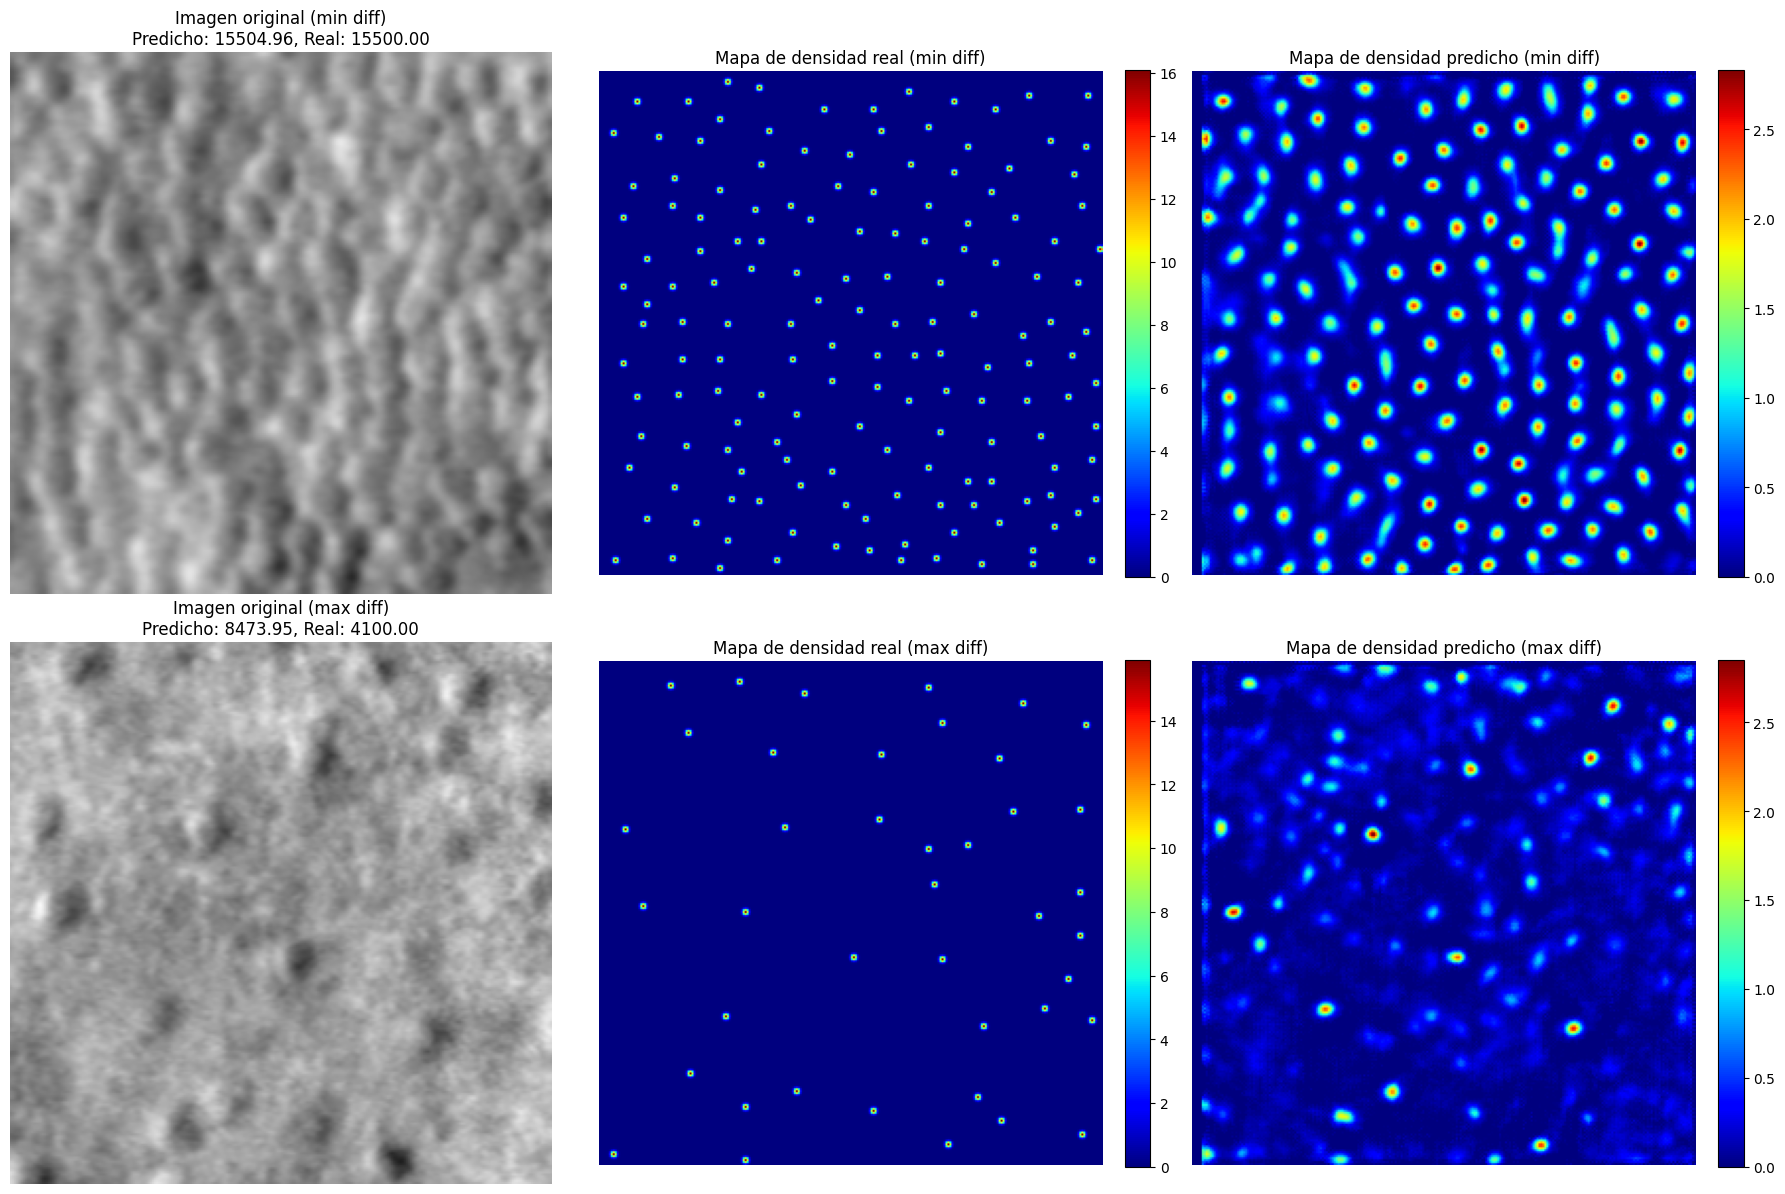

In [13]:
import statsmodels.api as sm

# Acumular todas las imágenes y mapas de densidad del conjunto de validación
val_images_all = []
val_density_all = []

for test_img, true_density in val_dataset:
    # Convertimos cada batch a numpy y lo acumulamos
    val_images_all.append(test_img.numpy())
    val_density_all.append(true_density.numpy())

# Concatenar todos los batches en un solo array
val_images_all = np.concatenate(val_images_all, axis=0)
val_density_all = np.concatenate(val_density_all, axis=0)

# Realizar predicciones en todas las imágenes de validación
val_predictions = model.predict(val_images_all)

# Calcular el conteo total (suma del mapa) para cada imagen
pred_counts = np.sum(val_predictions, axis=(1,2,3))
true_counts = np.sum(val_density_all, axis=(1,2,3))

# Calcular la diferencia absoluta entre el conteo real y el predicho
diff = np.abs(true_counts - pred_counts)

# Obtener los índices de la imagen con menor y mayor diferencia
min_idx = np.argmin(diff)
max_idx = np.argmax(diff)

# Preparar la gráfica para las imágenes con menor y mayor diferencia
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Caso de menor diferencia
min_pred_count = pred_counts[min_idx]
min_true_count = true_counts[min_idx]

# Imagen original con anotación en el título
axes[0, 0].imshow(val_images_all[min_idx])
axes[0, 0].set_title(f'Imagen original (min diff)\nPredicho: {min_pred_count:.2f}, Real: {min_true_count:.2f}')
axes[0, 0].axis('off')

# Mapa de densidad real con escala de colores
im_real_min = axes[0, 1].imshow(val_density_all[min_idx].squeeze(), cmap='jet')
axes[0, 1].set_title('Mapa de densidad real (min diff)')
axes[0, 1].axis('off')
plt.colorbar(im_real_min, ax=axes[0, 1], fraction=0.046, pad=0.04)

# Mapa de densidad predicho con escala de colores
im_pred_min = axes[0, 2].imshow(val_predictions[min_idx].squeeze(), cmap='jet')
axes[0, 2].set_title('Mapa de densidad predicho (min diff)')
axes[0, 2].axis('off')
plt.colorbar(im_pred_min, ax=axes[0, 2], fraction=0.046, pad=0.04)

# Caso de mayor diferencia
max_pred_count = pred_counts[max_idx]
max_true_count = true_counts[max_idx]

# Imagen original con anotación en el título
axes[1, 0].imshow(val_images_all[max_idx])
axes[1, 0].set_title(f'Imagen original (max diff)\nPredicho: {max_pred_count:.2f}, Real: {max_true_count:.2f}')
axes[1, 0].axis('off')

# Mapa de densidad real con escala de colores
im_real_max = axes[1, 1].imshow(val_density_all[max_idx].squeeze(), cmap='jet')
axes[1, 1].set_title('Mapa de densidad real (max diff)')
axes[1, 1].axis('off')
plt.colorbar(im_real_max, ax=axes[1, 1], fraction=0.046, pad=0.04)

# Mapa de densidad predicho con escala de colores
im_pred_max = axes[1, 2].imshow(val_predictions[max_idx].squeeze(), cmap='jet')
axes[1, 2].set_title('Mapa de densidad predicho (max diff)')
axes[1, 2].axis('off')
plt.colorbar(im_pred_max, ax=axes[1, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

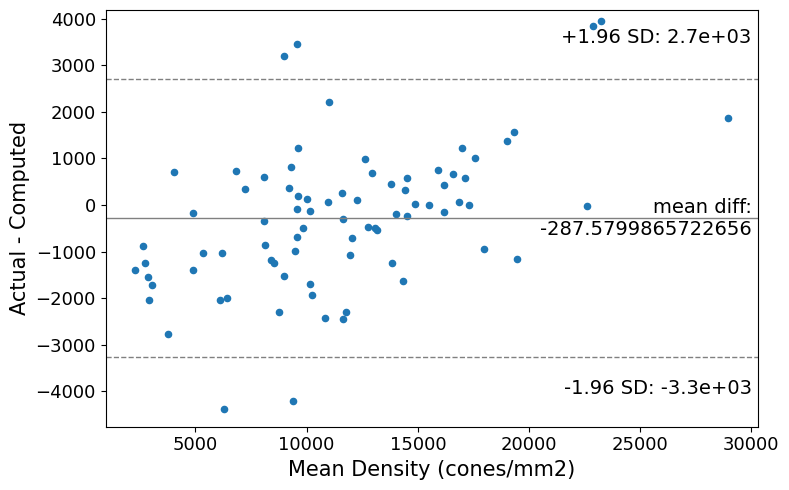

In [14]:
# Gráfico de mean-diff (Bland–Altman)
f, ax = plt.subplots(1, figsize=(8, 5))
sm.graphics.mean_diff_plot(true_counts, pred_counts, ax=ax)
plt.ylabel('Actual - Computed')
plt.xlabel('Mean Density (cones/mm2)')
plt.show()

In [15]:
import pandas as pd

In [16]:
# Calculamos los conteos (suma de densidades)
true_counts = np.sum(val_density_all, axis=(1,2,3))
pred_counts = np.sum(val_predictions, axis=(1,2,3))

# Creamos un DataFrame con la información
results_df = pd.DataFrame({
    'Index': range(len(true_counts)),
    'True Count': true_counts,
    'Pred Count': pred_counts,
    'Difference (True-Pred)': true_counts - pred_counts
})

# Agregamos columna de diferencia absoluta
results_df['Abs Diff'] = np.abs(results_df['Difference (True-Pred)'])

# Agregamos columna de error porcentual (relativo al conteo real)
# Usamos un epsilon pequeño para evitar división por cero
epsilon = 1e-7
results_df['% Error'] = 100 * results_df['Abs Diff'] / (results_df['True Count'] + epsilon)

# Imprimimos las primeras filas
print(results_df.head(10))

# Si quieres ver estadísticas globales:
print("\nEstadísticas globales:")
print(results_df.describe())

   Index    True Count    Pred Count  Difference (True-Pred)     Abs Diff  \
0      0   8400.000000   7803.466797              596.533203   596.533203   
1      1   5400.000000   7393.829590            -1993.829590  1993.829590   
2      2   7599.999512   9906.420898            -2306.421387  2306.421387   
3      3  14900.000000  14878.800781               21.199219    21.199219   
4      4   2400.000000   5173.912109            -2773.912109  2773.912109   
5      5  25200.001953  21256.548828             3943.453125  3943.453125   
6      6   7300.000000  11505.753906            -4205.753906  4205.753906   
7      7   4800.000000   4982.963379             -182.963379   182.963379   
8      8   7700.000488   8554.352539             -854.352051   854.352051   
9      9   5100.000000   7136.829102            -2036.829102  2036.829102   

      % Error  
0    7.101586  
1   36.922768  
2   30.347652  
3    0.142277  
4  115.579674  
5   15.648623  
6   57.613064  
7    3.811737  
8   11.0

In [17]:
from sklearn.metrics import r2_score

y_true, y_pred = [], []

# Recorremos todo el validation set sin alterar el grafo
for batch_x, batch_y in val_dataset:
    preds = model(batch_x, training=False)
    y_true.append(batch_y.numpy().ravel())
    y_pred.append(preds.numpy().ravel())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Métricas
mae  = np.mean(np.abs(y_true - y_pred))
mse  = np.mean((y_true - y_pred)**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2   = r2_score(y_true, y_pred)
corr = np.corrcoef(y_true, y_pred)[0,1]

print(f"MAE : {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f} %")
print(f"R²  : {r2:.3f}")
print(f"ρ   : {corr:.3f}")

MAE : 0.278
MSE: 1.205
RMSE: 1.098
MAPE: nan %
R²  : 0.104
ρ   : 0.323


<ipython-input-17-536331858>:18: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
<ipython-input-17-536331858>:18: RuntimeWarning: invalid value encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


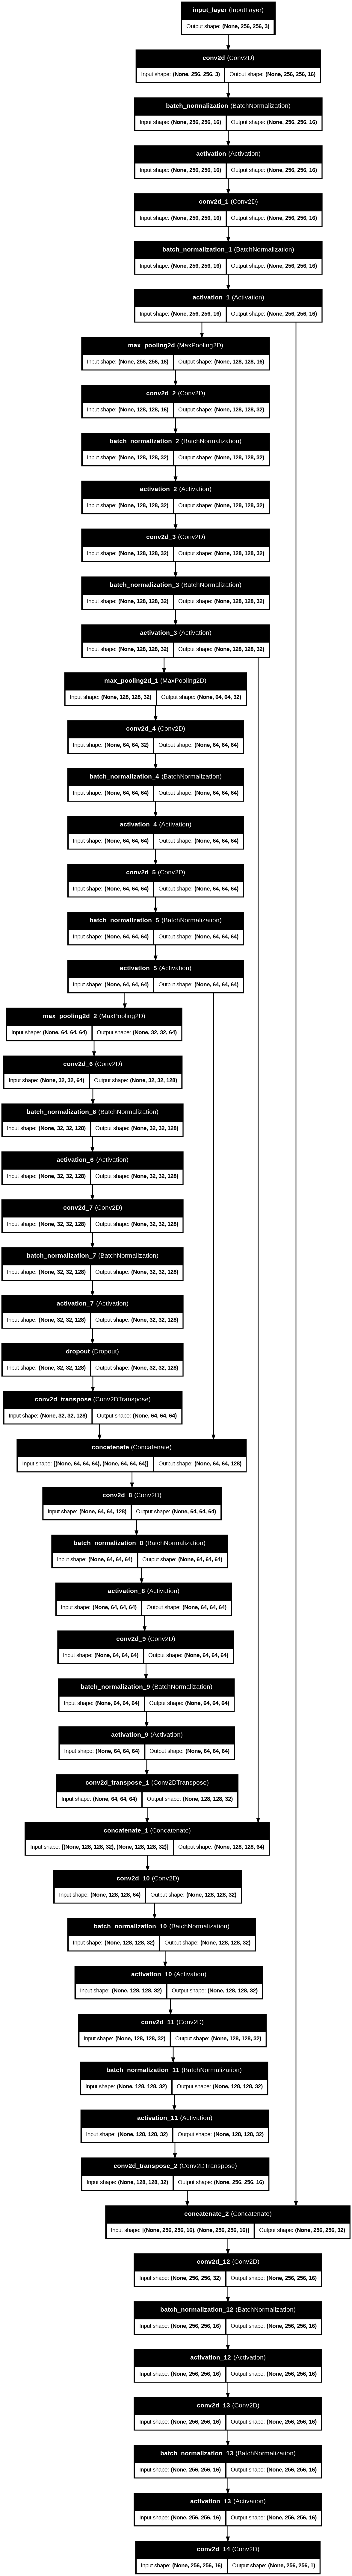

In [18]:

!pip install -q pydot graphviz


from tensorflow.keras.utils import plot_model


plot_model(model,
           to_file='unet_architecture.png',
           show_shapes=True,         # muestra (H, W, C) por capa
           show_layer_names=True,    # muestra nombres
           expand_nested=False,      # no expande sub-modelos
           dpi=96)                   # resolución aceptable para colab


from IPython.display import Image
Image('unet_architecture.png')